In [1]:
import pickle as pk
import matplotlib.pyplot as plt
import numpy as np
import corner
import emcee
import pymaster
import camb
import healpy as hp
import scipy.optimize as opt

In [2]:
Data1 = pk.load(open('Data.pkl','rb'))
Data2 = pk.load(open('Data_cross.pkl','rb'))
Data3 = pk.load(open('Data_comb.pkl','rb'))

In [3]:
Data1.keys()

dict_keys(['lensed_mean', 'delensed_mean', 'lensed_std', 'delensed_std', 'bias_mean', 'bias_std', 'lensing_theory'])

In [4]:
b = pymaster.NmtBin.from_nside_linear(512,10)

def get_spectra(r=0):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
    pars.InitPower.set_params(As=2e-9, ns=0.965, r=r)
    pars.set_for_lmax(2500, lens_potential_accuracy=0)
    pars.WantTensors = True if r is not 0 else False
    print("Setting Cosmology")
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    print("Power Spectra computed")
    return powers

def get_BB(component,r=0):
    result = get_spectra(r)
    if component == 'T':
        return result['tensor'].T[2]
    elif component == 'S':
        return result['lensed_scalar'].T[2]

def get_beam(beam):
    fwhm = hp.gauss_beam(np.radians(beam/60.),b.lmax,True)[:,2]
    return b.bin_cell(fwhm)
def get_noise(level):
    return np.ones(len(b.get_effective_ells())) * (np.radians(level/60)**2)

def get_bandpower(component, r=0, in_dl=True):
    bandpower = get_BB(component,r)
    l = b.get_effective_ells()
    dl = l*(l+1)/(2*np.pi) if not in_dl else np.ones(l.shape)
    print("Bandpower calculated")
    return l,b.bin_cell(bandpower[:b.lmax + 1])  / dl

def get_bandpower_cstm(fid,in_dl=True):
    l = b.get_effective_ells()
    dl = l*(l+1)/(2*np.pi) if in_dl else np.ones(l.shape)
    return l, b.bin_cell(fid[:b.lmax+1]) * dl



In [5]:
l, tensor = get_bandpower('T',r=1,in_dl=False)

Setting Cosmology
Power Spectra computed
Bandpower calculated


In [6]:
l, lensing = get_bandpower_cstm(Data1['lensing_theory'],in_dl=False)

# Biased Delensed Spectum

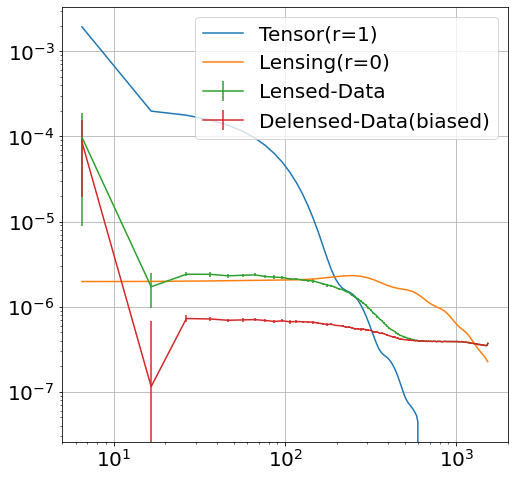

In [7]:
Data = Data1
plt.figure(figsize=(8,8))
plt.loglog(l,tensor,label='Tensor(r=1)')
plt.loglog(l,lensing,label='Lensing(r=0)')
plt.errorbar(l,Data['lensed_mean'],yerr=Data['lensed_std'],label='Lensed-Data')
plt.errorbar(l,Data['delensed_mean'],yerr=Data['delensed_std'],label='Delensed-Data(biased)')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.legend(fontsize='20')
plt.grid()

# Debiased Spectrum

# $C_\ell^{debiased} = C_\ell^{biased} - B_\ell^{Gaussian}$

In [8]:
lensing_model = lensing*get_beam(30)**2 + get_noise(2.15)
debiased_delensed_mean = Data['delensed_mean'] - Data['bias_mean']
debiased_delensed_std = np.sqrt(Data['delensed_std']**2 + Data['bias_std']**2)

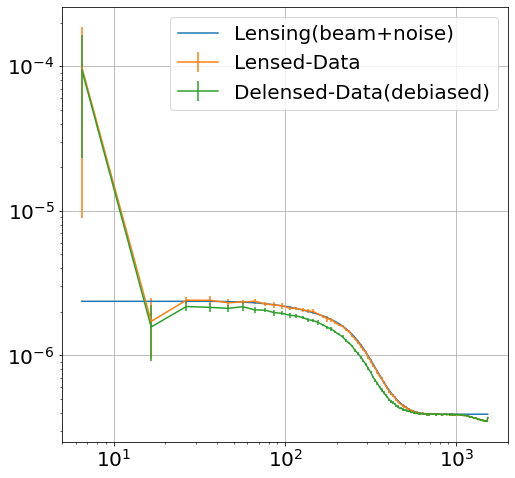

In [9]:
plt.figure(figsize=(8,8))
plt.loglog(l,lensing_model,label='Lensing(beam+noise)')
plt.errorbar(l,Data['lensed_mean'],yerr=Data['lensed_std'],label='Lensed-Data')
plt.errorbar(l,debiased_delensed_mean,yerr=debiased_delensed_std,label='Delensed-Data(debiased)')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.legend(fontsize='20')
plt.grid()

In [10]:
data1 = (Data1['lensed_mean'],Data1['lensed_std'],Data1['delensed_mean'],Data1['delensed_std'],Data1['bias_mean'],Data1['bias_std'])
data2 = (Data2['lensed_mean'],Data2['lensed_std'],Data2['delensed_mean'],Data2['delensed_std'],Data2['bias_mean'],Data2['bias_std'])
data3 = (Data3['lensed_mean'],Data3['lensed_std'],Data3['delensed_mean'],Data3['delensed_std'],Data3['bias_mean'],Data3['bias_std'])

# Spectra Difference

In [11]:
def spectra_dif(len_m,len_s,del_m,del_s,bias_m,bias_s):
    diff_m = del_m  - len_m -bias_m
    diff_s = del_s**2 + len_s**2 + bias_s**2
    return diff_m, np.sqrt(diff_s)

In [16]:
spectra_diff_mean, spectra_diff_std = spectra_dif(*data3)

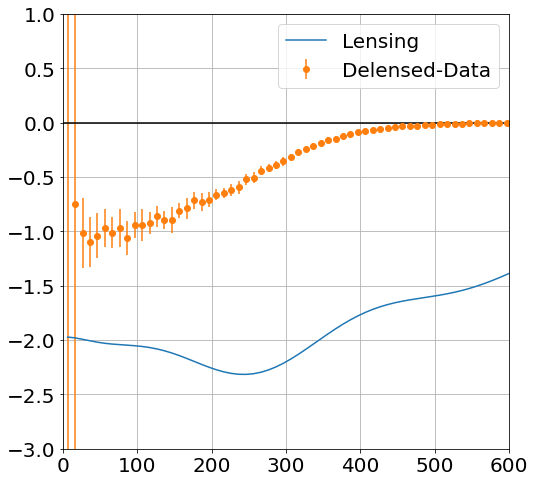

In [17]:
plt.figure(figsize=(8,8))
plt.plot(l,-lensing*10**6,label='Lensing')
plt.errorbar(l,spectra_diff_mean*10**6,yerr=spectra_diff_std*10**6,fmt='o',label='Delensed-Data')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.legend(fontsize='20')
plt.axhline(0,c='k')
plt.xlim(0,600)
plt.ylim(-3,1)
plt.grid()

# Efficency
from planck 2018 Gravitaional Lensing,
# $ \chi^2 = \sum \frac{([C_\ell^{del} - C_\ell^{data}] - \epsilon[C_\ell^{unlensed} - C_\ell^{lensed}])^2}{\sigma_\ell^2}$


in our case,
# $ \chi^2 = \sum \frac{([C_\ell^{del} - C_\ell^{data}] - \epsilon[0 - C_\ell^{BB}])^2}{\sigma_\ell^2}$

In [18]:
def fit_efficency(fiducial,data,lmin=20,lmax=200):
    x = b.get_effective_ells()
    
    mean, std = spectra_dif(*data)
   

    ref = b.bin_cell(fiducial[:b.lmax+1])#*get_beam(30)**2 + get_noise(2.15)
    sel = np.where((x >= lmin)& (x <= lmax))[0]
    def chi_sq(epsilon):
        num = mean[sel] - (epsilon * (0-ref[sel]) )
        return np.sum(num**2 / std[sel]**2)

    x0 = [.5]
    res = opt.minimize(chi_sq, x0)

    print(f"OPTIMISATION INFO: {res['message']}")
    print(f"OPTIMISATION INFO: Chisq_{len(sel)} = {res['fun']}")
    print(f"Efficency btw l={lmin} and l={lmax}: {res['x'][0]*100}")

    return res['x'][0]

In [21]:
epsilon = fit_efficency(Data['lensing_theory'],data3,lmin=20,lmax=200)

OPTIMISATION INFO: Desired error not necessarily achieved due to precision loss.
OPTIMISATION INFO: Chisq_18 = 28.497845787559267
Efficency btw l=20 and l=200: 39.019414446377375


# Fitting $r$

# $\chi^2 = \sum \frac{(C_\ell^{del}-C_\ell^{theory})^2}{\sigma^2}$

where, 
# $C_\ell^{theory} = (r C_\ell^{tensor}(r=1) + A_{lens}C_\ell^{lensing}) b_\ell^2 + N$

In [22]:
def fit_r_V1(lmin=20,lmax=200):
    x = b.get_effective_ells()
    sel = np.where((x >= lmin)& (x <= lmax))[0]
    
    beam = get_beam(30)
    noise = get_noise(1.5)

    def cl_theory(r,Alens):
        th = (r * tensor) + (Alens * lensing)
        return th*beam**2 + noise

    len_m, len_s, del_m, del_s, bias, bias_std = data

    def chi_sq(theta):
        r,Alens = theta
        th = cl_theory(r,Alens)
        std = np.sqrt(del_s[sel]**2 + bias_std[sel]**2)
        return np.sum((del_m[sel] - bias[sel] - th[sel])**2/std**2)
    
    def chi_sq_lensed(theta):
        r,Alens = theta
        th = cl_theory(r,Alens)
        std = len_s[sel]
        return np.sum((len_m[sel] - th[sel])**2/std**2)

    x0 = np.array([0.0,0.0])
    res = opt.minimize(chi_sq, x0)

    print(f"MLV:{res['x']}")

    def log_prior(theta):
        r,Alens= theta
        if  -0.5 < r < 0.5 and 0 < Alens < 2.:
            return 0.0
        return -np.inf

    def log_probability(theta):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        #return lp  -.5*chi_sq_lensed(theta)
        return lp  -.5*chi_sq(theta)

    def posterior():
        pos = np.array(res['x']) + 1e-4 * np.random.randn(100, 2)
        nwalkers, ndim = pos.shape
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
        sampler.run_mcmc(pos, 2000, progress=True)
        flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

        labels = ["r","Alens"]
        fig = corner.corner(flat_samples, labels=labels,truths=[0,0])
        #return flat_samples
    
    return posterior()
    

  1%|          | 12/2000 [00:00<00:17, 113.65it/s]

MLV:[4.24130443e-04 9.65684887e-01]


100%|██████████| 2000/2000 [00:19<00:00, 100.98it/s]


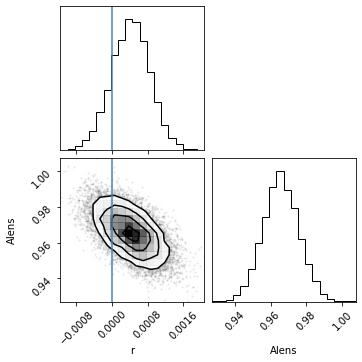

In [23]:
fit_r_V1(lmin=20,lmax=200)

# ************* Phys. Rev. D 73, 023517  *************
# Fitting $r$ 

Eq(28) from Hamimeche and Lewis 2008,

# $-2 \mathcal{L}(C_\ell| \hat C_\ell) \sim (2\ell +1) \frac{9}{2} \left( \frac{2\ell + \alpha}{2\ell + 1}\right)^{1/3} \times  \left[ \left(\frac{\hat C_\ell}{C_\ell} \right)^{1/3} - \left( \frac{2\ell + \alpha}{2\ell + 1}\right)^{1/3} \right]^2 + (1-\alpha)\text{ln}C_\ell$

where, 
# $C_\ell= (r C_\ell^{tensor}(r=1) + A_{lens}C_\ell^{lensing}) b_\ell^2 + N$

In [36]:
def fit_r_smith(lmin=30,lmax=200,lensed=False,ini=.5):
    x = b.get_effective_ells()
    sel = np.where((x >= lmin)& (x <= lmax))[0]
    l = x
    
    beam = get_beam(30)
    noise = get_noise(nlevp)

    def cl_theory(r,Alens):
        th = (r * tensor) + (Alens * lensing)
        return th*beam**2 + noise

    len_m, len_s, del_m, del_s, bias, bias_std = dataV

    def chi_sq(theta):
        alpha = -1
        r,Alens = theta
        th = cl_theory(r,Alens)
        debiased = (del_m - bias) if not lensed else len_m
        _1 = (2*l) + 1
        _a = (2*l) + alpha
        _f = 9/2
        _2 = ((_1)/(_a))**(1/3.)
        
        first = _1*_f*_2
        second = ((debiased/th)**(1/3.) -_2)**2
        third = (1-alpha)*np.log(th)
        
        chi = (first*second) + third
        
        return  np.sum(chi[sel])
        
        
    

    x0 = np.array([0.,ini])
    res = opt.minimize(chi_sq, x0)

    print(f"MLV:{res['x']}")

    def log_prior(theta):
        r,Alens= theta
        if  -0.5 < r < 0.5 and 0 < Alens < 2.:
            return 0.0
        return -np.inf

    def log_probability(theta):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp - .5*chi_sq(theta)

    def posterior():
        pos = np.array(res['x']) + 1e-4 * np.random.randn(100, 2)
        nwalkers, ndim = pos.shape
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
        sampler.run_mcmc(pos, 2000, progress=True)
        flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

        labels = ["r","Alens"]
        fig = corner.corner(flat_samples, labels=labels,truths=[0,0])
        #return flat_samples
    
    return posterior()

  0%|          | 0/2000 [00:00<?, ?it/s]/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in power
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log
  1%|          | 11/2000 [00:00<00:18, 106.25it/s]

MLV:[-3.73696925e-04  9.82830875e-01]


100%|██████████| 2000/2000 [00:19<00:00, 101.58it/s]


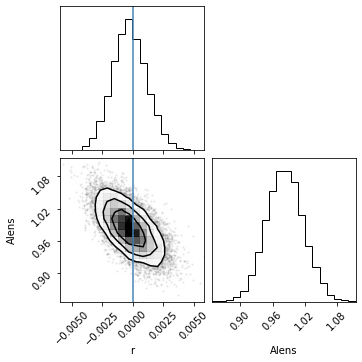

In [37]:
fit_r_smith(data1,lmin=30,lmax=200,lensed=True,ini=.8)

  0%|          | 0/2000 [00:00<?, ?it/s]/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in power
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log
  1%|          | 11/2000 [00:00<00:19, 104.30it/s]

MLV:[5.82658585e-04 8.19224599e-01]


100%|██████████| 2000/2000 [00:20<00:00, 96.90it/s] 


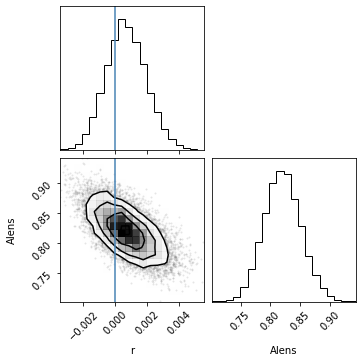

In [38]:
fit_r_smith(data1,lmin=30,lmax=200,ini=.8)

/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in power
  0%|          | 10/2000 [00:00<00:20, 94.98it/s]

MLV:[9.28112567e-05 4.64200895e-01]


100%|██████████| 2000/2000 [00:21<00:00, 94.85it/s] 


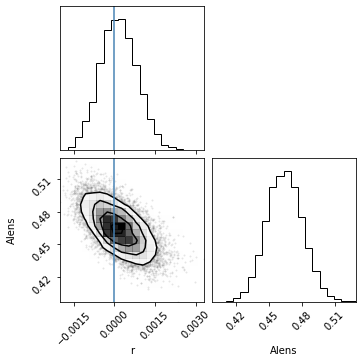

In [39]:
fit_r_smith(data3,1.5,lmin=30,lmax=200,ini=.3)

/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in power
  0%|          | 10/2000 [00:00<00:21, 93.45it/s]

MLV:[0.0011625  0.50519098]


100%|██████████| 2000/2000 [00:20<00:00, 97.04it/s] 


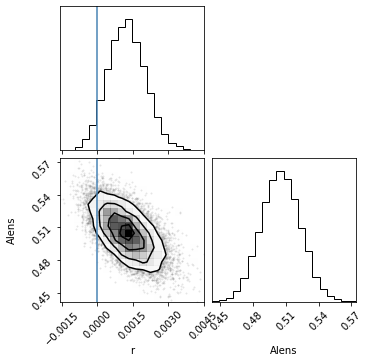

In [40]:
fit_r_smith(data2,1.5,lmin=30,lmax=200,ini=.4)